# 1. Importing Libraries

In [1]:
import os
import cv2
import time
import uuid
import json
import labelme
import numpy as np
import tensorflow as tf
import albumentations as alb
import matplotlib.pyplot as plt

# 2. Data Collection

### 2.1 Collecting Data using OpenCV

In [2]:
IMAGE_PATH = os.path.join('dataset', 'images')
num_of_img = 30

In [9]:
# the number 0 will change according to your OS, on windows it might be 1
cap = cv2.VideoCapture(0)
for imgnum in range(num_of_img):
    print(f'Collecting Image {imgnum}')
    ret, frame = cap.read()
    imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### 2.2 Annotate Images with Labelme

In [10]:
!labelme

2024-03-13 14:38:48,745 [INFO   ] __init__:get_config:67- Loading config file from: /Users/taimourabdulkarim/.labelmerc


# 3. Review Dataset and Build Image Loading Function

### 3.1 Load images into TF Pipeline

In [3]:
images = tf.data.Dataset.list_files('dataset/images/*.jpg')

2024-03-13 15:46:37.586901: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-13 15:46:37.586937: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-13 15:46:37.586942: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-13 15:46:37.587306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-13 15:46:37.587329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
images.as_numpy_iterator().next()

b'dataset/images/9a77ab0a-e11b-11ee-8085-0e47976fb6f8.jpg'

In [5]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
images = images.map(load_img)

In [7]:
images.as_numpy_iterator().next()

array([[[  3,   3,   1],
        [  7,   7,   5],
        [  1,   2,   0],
        ...,
        [173, 159, 133],
        [174, 160, 134],
        [182, 168, 142]],

       [[ 11,  11,   9],
        [  9,  10,   5],
        [  8,   9,   4],
        ...,
        [170, 156, 130],
        [173, 159, 133],
        [179, 165, 139]],

       [[ 15,  16,  11],
        [ 16,  17,  12],
        [ 12,  11,   7],
        ...,
        [173, 159, 133],
        [173, 159, 132],
        [176, 162, 135]],

       ...,

       [[191, 192, 186],
        [196, 197, 191],
        [194, 195, 189],
        ...,
        [ 33,  38,  32],
        [ 34,  39,  33],
        [ 39,  44,  38]],

       [[192, 195, 188],
        [192, 195, 188],
        [191, 194, 187],
        ...,
        [ 32,  39,  31],
        [ 25,  32,  25],
        [ 21,  28,  21]],

       [[193, 196, 189],
        [191, 194, 187],
        [195, 198, 191],
        ...,
        [ 23,  30,  22],
        [ 11,  18,  11],
        [ 29,  36,  29]]

In [8]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 3.2 View Raw Images with Matplotlib

In [9]:
img_gen = images.batch(4).as_numpy_iterator()

In [10]:
plot_images = img_gen.next()

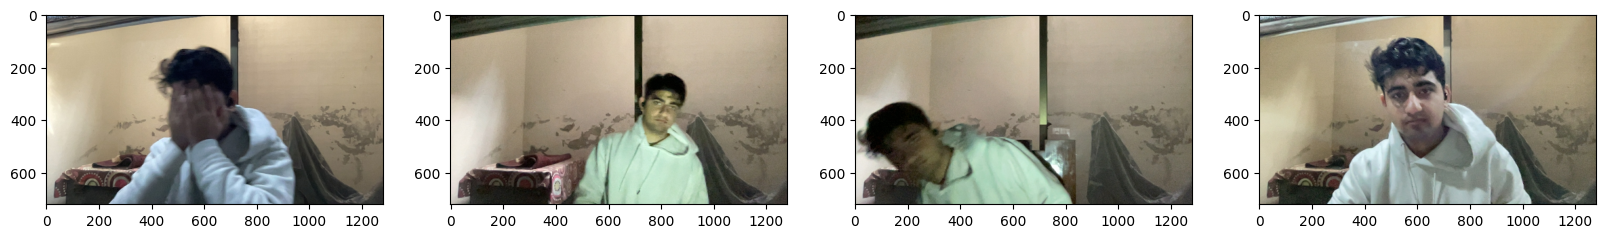

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(plot_images):
    ax[idx].imshow(img)
plt.show()

# 4. Partition Unaugmented Data

### 4.1 Manually move images to train test and val folders

In [29]:
90*0.7 # Train Images

62.99999999999999

In [30]:
90*0.2 # Val Images

18.0

In [31]:
90*0.1 # Test Images

9.0

In [32]:
18+9+63

90

### 4.2 Move the Matching Labels

In [6]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('dataset', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('dataset', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('dataset', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 5. Apply Image Augmentation

### 5.1 Make Albumentations Transform Pipleline

In [12]:
augmentor = alb.Compose(
    [
        alb.RandomCrop(width=450, height=450),
        alb.HorizontalFlip(p=0.5),
        alb.RandomBrightnessContrast(p=0.2),
        alb.RandomGamma(p=0.2),
        alb.RGBShift(p=0.2),
        alb.VerticalFlip(p=0.5),
    ],
    bbox_params=alb.BboxParams(format="albumentations", label_fields=["class_labels"]),
)

### 5.2 Load and Test Image

In [15]:
img = cv2.imread(
    "dataset/train/images/3a699cba-e11a-11ee-a34d-0e47976fb6f8.jpg"
)

In [16]:
with open(os.path.join("dataset", "train", "labels", "3a699cba-e11a-11ee-a34d-0e47976fb6f8.json"), 'r') as f:
    label = json.load(f)

In [17]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[526.5384615384614, 156.1538461538463],
    [857.3076923076922, 560.0000000000001]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '../images/3a699cba-e11a-11ee-a34d-0e47976fb6f8.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRC

In [18]:
label['shapes'][0]['points']

[[526.5384615384614, 156.1538461538463],
 [857.3076923076922, 560.0000000000001]]

### 5.3 Extract Coordinates and Rescale to Match Image Resolution

In [23]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

coords

[526.5384615384614, 156.1538461538463, 857.3076923076922, 560.0000000000001]

In [24]:
# adjust the size according to camera 
coords = list(np.divide(coords, [1280, 720, 1280, 720]))
coords

[0.411358173076923,
 0.21688034188034208,
 0.6697716346153845,
 0.7777777777777779]

### 5.4 Apply Augmentation

In [25]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])

In [27]:
augmented['bboxes']

[(0.6056410256410254, 0.14222222222222192, 1.0, 1.0)]

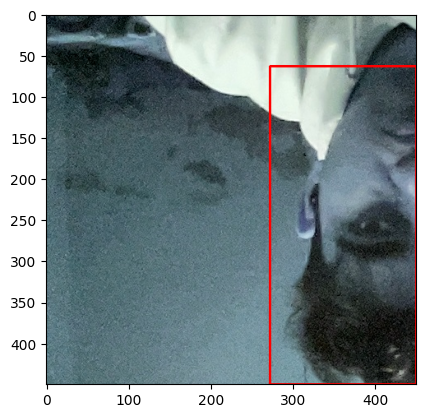

In [28]:
cv2.rectangle(
    augmented["image"],
    tuple(np.multiply(augmented["bboxes"][0][:2], [450, 450]).astype(int)),
    tuple(np.multiply(augmented["bboxes"][0][2:], [450, 450]).astype(int)),
    (255, 0, 0),
    2,
)

plt.imshow(augmented["image"])

# 6. Build and Run Augmentation Pipeline